In [120]:
import pandas as pd
import random 
import numpy as np
import re


In [121]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline


In [122]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

In [155]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [124]:
train = pd.read_csv(r"C:\Users\angel\Desktop\bootcamp\train.tsv", sep='\t')
test = pd.read_csv(r"C:\Users\angel\Desktop\bootcamp\test.tsv", sep='\t')

In [125]:

def data(n, seed):

    datas = []
    
    random.seed(seed)
    for i in range(n):
        dia_maximo = 30
        dia_minimo = 1
        mes_maximo = 12
        mes_minimo = 1
        
        dia = int(round(random.random() * (dia_maximo - dia_minimo) + dia_minimo, 0))
        mes = int(round(random.random() * (mes_maximo - mes_minimo) + mes_minimo, 0))
        
        datas.append(str(dia)+'-'+str(mes)+'-2018')
        
    return datas

def estoque(n, seed):

    np.random.seed(seed)
    mu, sigma = 1, 20
    s = np.random.normal(mu, sigma, n)
    s[s < 0] = s[s < 0] * -0.5
    s = s.astype(int)
    s[s < 1] = 1
    
    return s

train['date']  = data(n = train.shape[0], seed = 10)
train['stock'] = estoque(n = train.shape[0], seed = 10)

test['date']  = data(n = test.shape[0], seed = 15)
test['stock'] = estoque(n = test.shape[0], seed = 15)

train.drop('train_id', axis=1, inplace=True)
train['item_condition_id'] = train['item_condition_id'].astype('str')

In [126]:
from numpy.lib.function_base import delete

rotulos = [i for i in train['category_name'].fillna('missing/missing/missing').str.split("/")]
rotulos

gen_cat = []
sub1_cat = []
sub2_cat = []

for i in range(0,len(rotulos)):
  gen_cat.append(rotulos[i][0])
  sub1_cat.append(rotulos[i][1])
  sub2_cat.append(rotulos[i][2])

train['gen_cat'] = gen_cat
train['sub1_cat'] = sub1_cat
train['sub2_cat'] = sub2_cat

del gen_cat
del sub1_cat
del sub2_cat

In [127]:
train.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description,date,stock,gen_cat,sub1_cat,sub2_cat
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,18-6-2018,27,Men,Tops,T-shirts
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,18-3-2018,15,Electronics,Computers & Tablets,Components & Parts
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,25-10-2018,14,Women,Tops & Blouses,Blouse
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,20-3-2018,1,Home,Home Décor,Home Décor Accents
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,16-5-2018,13,Women,Jewelry,Necklaces


In [128]:
train.drop("category_name", axis = 1, inplace=True)

In [129]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   name               1482535 non-null  object 
 1   item_condition_id  1482535 non-null  object 
 2   brand_name         849853 non-null   object 
 3   price              1482535 non-null  float64
 4   shipping           1482535 non-null  int64  
 5   item_description   1482531 non-null  object 
 6   date               1482535 non-null  object 
 7   stock              1482535 non-null  int32  
 8   gen_cat            1482535 non-null  object 
 9   sub1_cat           1482535 non-null  object 
 10  sub2_cat           1482535 non-null  object 
dtypes: float64(1), int32(1), int64(1), object(8)
memory usage: 118.8+ MB


In [130]:
train.describe()

,price,shipping,stock
count,1.482535e+06,1.482535e+06,1.482535e+06
mean,2.673752e+01,4.472744e-01,1.178544e+01
std,3.858607e+01,4.972124e-01,1.056072e+01
min,0.000000e+00,0.000000e+00,1.000000e+00
25%,1.000000e+01,0.000000e+00,4.000000e+00
50%,1.700000e+01,0.000000e+00,9.000000e+00
75%,2.900000e+01,1.000000e+00,1.700000e+01
max,2.009000e+03,1.000000e+00,9.500000e+01


In [131]:
train.isnull().sum()

name                      0
item_condition_id         0
brand_name           632682
price                     0
shipping                  0
item_description          4
date                      0
stock                     0
gen_cat                   0
sub1_cat                  0
sub2_cat                  0
dtype: int64

In [132]:
train.duplicated().sum()

0

In [133]:
train["brand_name"].fillna("missing", inplace=True)

In [134]:
train = train.dropna()

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'shipping'}>],
       [<AxesSubplot:title={'center':'stock'}>, <AxesSubplot:>]],
      dtype=object)

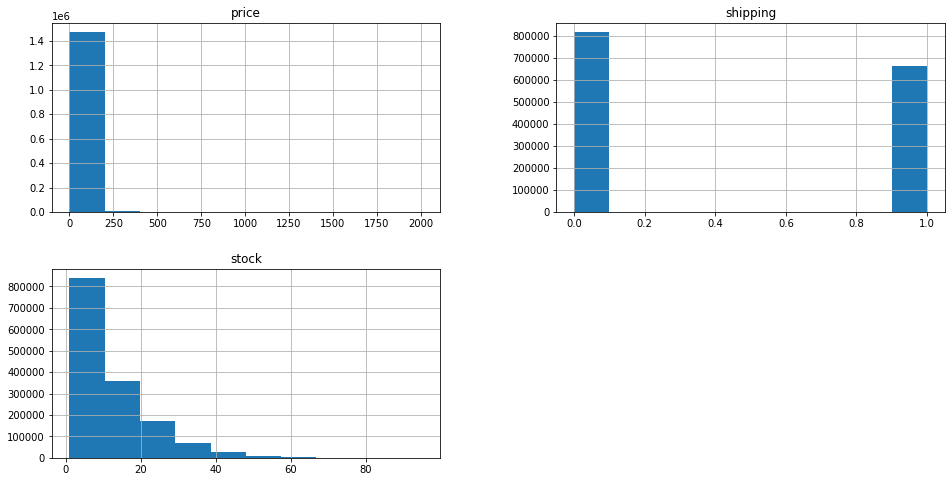

In [135]:
train.hist(figsize=(16,8))

In [136]:
X = train.drop("price", axis = 1)
y = train["price"]

In [137]:
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.1, random_state=10)

<AxesSubplot:>

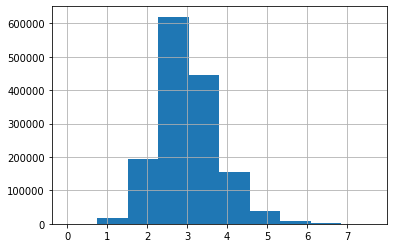

In [138]:
y_log =  np.log1p(y)
y_log.hist()

In [139]:
Xtrain.drop("date", axis=1, inplace=True)

In [140]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1334277 entries, 1307655 to 1393933
Data columns (total 9 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   name               1334277 non-null  object
 1   item_condition_id  1334277 non-null  object
 2   brand_name         1334277 non-null  object
 3   shipping           1334277 non-null  int64 
 4   item_description   1334277 non-null  object
 5   stock              1334277 non-null  int32 
 6   gen_cat            1334277 non-null  object
 7   sub1_cat           1334277 non-null  object
 8   sub2_cat           1334277 non-null  object
dtypes: int32(1), int64(1), object(7)
memory usage: 96.7+ MB


In [141]:
Xtrain.head()

,name,item_condition_id,brand_name,shipping,item_description,stock,gen_cat,sub1_cat,sub2_cat
1307655,Funko Cookie Monster New York Comic Con,1,missing,1,New in box Funko Flocked Cookie Monster New Yo...,15,Vintage & Collectibles,Collectibles,Other
529568,Nike lebrons James toddler shoes bundle,3,Nike,1,In excellent condition nike lebrons No box. Si...,13,Kids,Boys 2T-5T,Shoes
88301,TOMS flat shoes sz 8 denim look,3,TOMS,1,TOMS flat shoes sz 8 denim look Great Conditio...,20,Women,Shoes,Loafers & Slip-Ons
555225,Red Plaid Blanket Vest LARGE,1,missing,0,Up your vest game this season with this Plaid ...,7,Women,Coats & Jackets,Vest
647485,Clinique foundation,2,Clinique,0,New in box! Foundation +concealer Color is 0.5...,22,Beauty,Skin Care,Face


In [169]:

ColumnTransformer = make_column_transformer(
    (OneHotEncoder(sparse=False),["shipping","gen_cat","sub1_cat","sub2_cat"]),
    (TfidfVectorizer(),"name" ),
    (TfidfVectorizer(),"item_description" ),
    remainder="passthrough",
    sparse_threshold=0
)

In [173]:
rf = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
Lr = LinearRegression()

In [176]:
pipe = make_pipeline(ColumnTransformer, Lr)

In [ ]:
model = pipe.fit(Xtrain,y_log)